# Maria's notebook

Analysis of miscarriage and depression using Twitter data from relevant dates to the topic. I will explore:
1. Most prolific authors
2. Tweets/day
3. Correlation
4. Sentiment analysis related to popularity

### Import the neccesary libraries and modules to the notebook

In [1]:
#Data operations (visualize and manipulate)

import json
import missingno as msno
import csv
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series

In [2]:
#Packages for text cleaning 

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
#Time and dates management

from datetime import datetime
import time

In [4]:
#Sentiment analysis

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
#nltk.downloader.download('vader_lexicon')
from textblob import TextBlob

In [5]:
#Topic extraction

import gensim
from gensim import corpora, models
from gensim.matutils import jaccard
from gensim.models import LdaModel
from gensim.models import CoherenceModel

In [6]:
#Data visualization

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

The data that will be used is stored in the DataCollection folder. 


In [7]:
path_tweets = 'dataCollection/tweets_miscarriage_all_wo_reply.json'
print(path_tweets)

dataCollection/tweets_miscarriage_all_wo_reply.json


In [8]:
#A list is created with all the collected tweets & metadata (author, date, time, metrics, etc).

tweets = list()
n = 0
#To make sure all tweets are read
max_row = 10000000  

#Open(.., 'r') only read mode. t=tweets & l=loads
with open(path_tweets, 'r') as t: 
    for l in t: 
        tweets.append(json.loads(l))    #Creates a diccionary

#Creation of a dataframe with all the compiled information
df = pd.DataFrame(tweets)

In [9]:
#Visualize the dataframe and its columns
print(f'This is the original columns without any transformation: {df.columns}\n')

#Take a sample from the population
#df = df.sample(n = 10000, axis=0)
len_initial = len(df)

print(f"The dataframe has {len(df)} entries\n")
print(f"The dataframe has {len(df.axes[1])} columns or observations\n")


This is the original columns without any transformation: Index(['_id', 'id', 'author', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'public_metrics', 'text',
       'referenced_tweets', 'attachments', 'geo', 'withheld'],
      dtype='object')

The dataframe has 97965 entries

The dataframe has 14 columns or observations



In [10]:
#Createa a function to normalize the json data and transform into a dictionary format 
def normalized_data(df, col):
    df2 = pd.json_normalize(df[col])
    df2.columns = ['{}.{}'.format(col, x) for x in df2.columns]
    df = df.join(df2)
    del df[col]
    return df

In [11]:
#Apply transformations on the fields of our interest
df = normalized_data(df, 'author')
df = normalized_data(df, 'public_metrics')
df = normalized_data(df, 'geo')

In [12]:
#Print again to watch the transformation on the columns
print(f"These are the new columns: {df.columns}\n")

These are the new columns: Index(['_id', 'id', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'text', 'referenced_tweets',
       'attachments', 'withheld', 'author.id', 'author.username',
       'author.created_at', 'author.name', 'author.location',
       'author.withheld.country_codes', 'author.withheld.scope',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'geo.place_id', 'geo.country', 'geo.full_name', 'geo.id',
       'geo.coordinates.type', 'geo.coordinates.coordinates'],
      dtype='object')



## Languaje filtering
After columns normalization and transformation we filter the tweets in english for the sentiment analysis. We also perform additional operations, but in this stance we wont obtain wether tweets are replies because the replies have not been obtained.

This function won't be necessary since the data collection did not include the replies:


def is_reply(df):
   
           df['is_reply'] = df['in_reply_to_user_id'].apply(lambda x: False if np.isnan(float(x)) else True)
            return df

In [13]:
#Filtering the tweets that are only in english
def filter_English_tweets(df):
    df = df[df['lang'] == 'en']
    return df

In [14]:
#New function that applies the previous ones to the df
def apply_transformations(df):

    df = filter_English_tweets(df) 
   # df = media_extraction(df)
    return df

In [15]:
#Apply the function for transformations
df = apply_transformations(df)
len_after = len(df)

In [16]:
print(f"Before filtering the tweets we had 97965 entries, while now that we excluded those not in english we have {len(df)} entries in the dataframe")

Before filtering the tweets we had 97965 entries, while now that we excluded those not in english we have 92296 entries in the dataframe


{'initial': 97965, 'after': 92296}


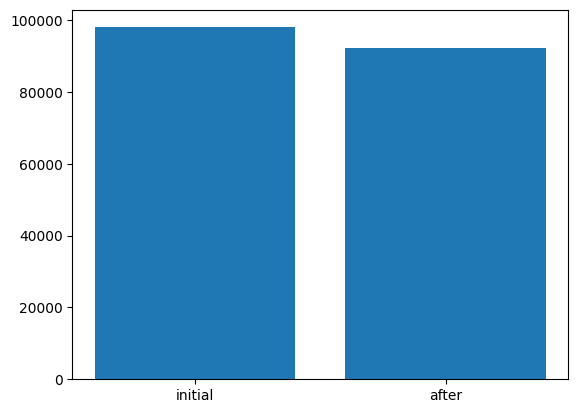

In [17]:
len_data = {'initial':len_initial, 'after':len_after}
print(len_data)

plt.bar(*zip(*len_data.items()))
plt.show()

<AxesSubplot: >

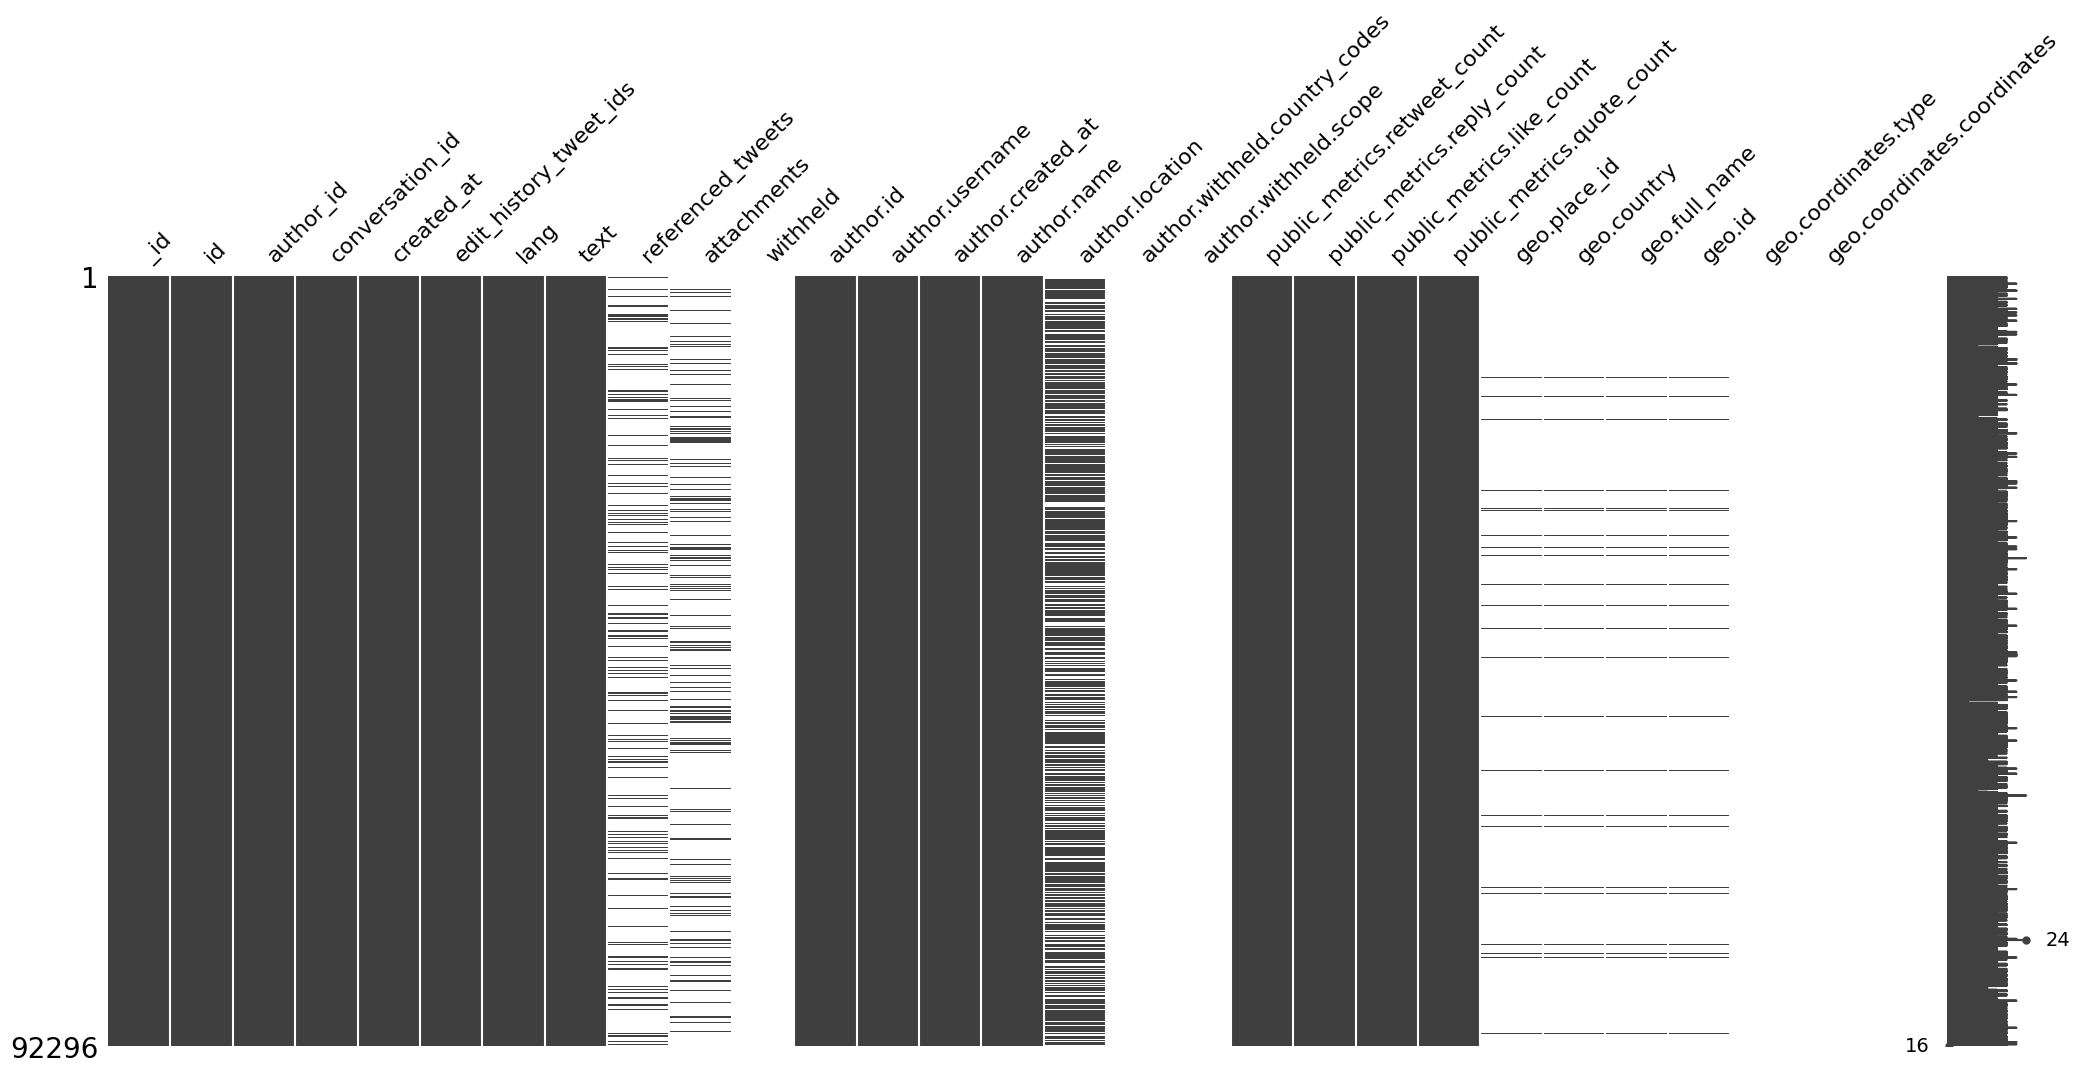

In [18]:
#This allows us to see the lenght (bottom left corner) as well as the density of information in each column 
msno.matrix(df)

### Text cleaning for the sentiment analysis

In [19]:
# Functions the mentioned text cleaning steps


# Removing extra spaces from all texts
def remove_extra_spaces(sentence):
    sentence = sentence.replace(r'\n',' ', regex=True) 
    sentence = sentence.replace(r'/\|/g',' ', regex=True) 
    return sentence


def lowercase_text(sentence):
    return sentence.lower()

def remove_usernames(sentence):
    sentence = re.sub(r'@\w+',' ', sentence)
    return sentence

def remove_hashtags(sentence):
    sentence = re.sub(r"#\w+",' ', sentence)
    return sentence

def remove_links(sentence):
    sentence = re.sub(r'\bhttps?://[^\s]*',' ', sentence)
    return sentence

def remove_numbers(sentence):
    sentence = re.sub(r'\d+',' ', sentence)
    return sentence

def remove_punctuation_and_spaces(sentence):
    sentence = re.sub(r'&', ' ', sentence) # Specific for &
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    sentence = ' '.join(sentence.split())
    return sentence

def remove_1letter_words(sentence):
    sentence = re.sub(r'\b\w{1}\b', ' ', sentence)
    return sentence

def tokenize(sentence):
    list_of_words = sentence.split(" ")
    return list_of_words

def remove_stopwords(list_of_words):
    # Getting English stopwords
    stop_words = set(stopwords.words('english'))

    filtered_words = []
    for word in list_of_words: 
        if word not in stop_words: 
            filtered_words.append(word) 

    return filtered_words

def lemmatize(list_of_words):
    # Getting English lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    lemma_words = []
    for w in list_of_words:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n") # Names
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v") # Verbs
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a") # Adjectives
        lemma_words.append(word3)

    return lemma_words


     

# Function to apply all text tranformations
def text_cleaning(df):
    '''
    Given a pandas dataframe with tweets returns a list of clean tweet texts
    @input: pandas dataframe with tweets
    @output: list of clean tweets (same order as in df)
    '''
    lists_of_text = []

    for text in df['text']:
        sentence = str(text)

        # Text transformations
        sentence = lowercase_text(sentence) # All in lowercase
       # sentence = remove_extra_spaces(sentence)

        sentence = remove_links(sentence) # Remove links
        sentence = remove_hashtags(sentence) # Remove Hashtags
        sentence = remove_usernames(sentence) # Remove usernames
        sentence = remove_numbers(sentence) # Remove numbers
        sentence = remove_punctuation_and_spaces(sentence) # Remove punctuation signs and multiple spaces
        sentence = remove_1letter_words(sentence) # Remove words with len=1
        sentence = remove_punctuation_and_spaces(sentence)
        
        list_of_words = tokenize(sentence) # Tokenization
        list_of_words = remove_stopwords(list_of_words) # Remove stopwords
        list_of_words = lemmatize(list_of_words) # Lemmatization
        
        # Converting list of words to text again
        lists_of_text.append(' '.join(list_of_words))

    return lists_of_text

In [20]:
df['clean_text'] = text_cleaning(df)

# Authors
We want to see the authors that have contributed the most to the total amount of tweets during the selected days.

In [21]:
#We wish to obtain the authors with most contributions, we group them by name and order (ascending)

most_prolific = df.groupby('author.username').size().sort_values(ascending = False)
most_prolific

author.username
TomthunkitsMind    462
LifeNewsHQ         134
littlebytesnews    127
LifeNewsToo        127
Inspiredtvgh       119
                  ... 
NewsUSAofficial      1
NewsViews_           1
NewsVirginian        1
NewsWire_US          1
zzzi_ki              1
Length: 54013, dtype: int64

In [22]:
#We transform it into a data frame and reset the index to transform the name of the author (which is used as an index atm)

#To transform index into column we use .reset_index()

df_most_prolific = pd.DataFrame(most_prolific).reset_index()

In [23]:
df_most_prolific.columns = ["author_id", "count"]

In [24]:
df_most_prolific_15_most = df_most_prolific.head(15)
df_most_prolific_15_most

,author_id,count
0,TomthunkitsMind,462
1,LifeNewsHQ,134
2,littlebytesnews,127
3,LifeNewsToo,127
4,Inspiredtvgh,119
5,zhouzhoujyk,109
6,SafetyPinDaily,109
7,youkayoyo10059,107
8,g_kraig,102
9,br00t4c,97


Text(0, 0.5, 'Author username')

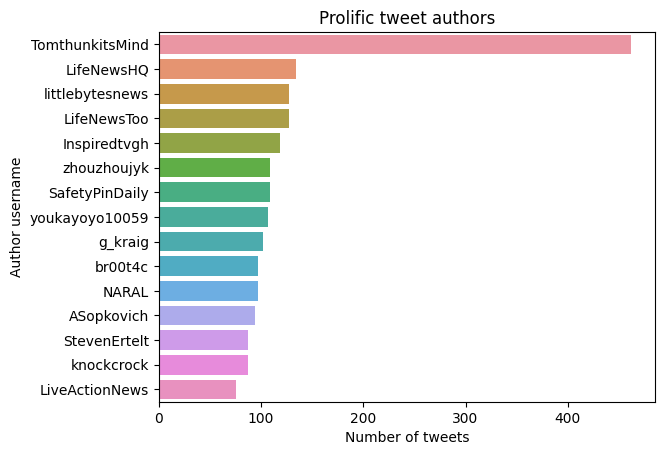

In [25]:
sns.barplot(
    x = df_most_prolific_15_most['count'],
     y = df_most_prolific_15_most['author_id'])
plt.title("Prolific tweet authors")
plt.xlabel("Number of tweets")
plt.ylabel("Author username")

## Dates
Explore as well the dates where the tweets were made, to compare between them. 

In [26]:
# Transform into date time object ( datetime 64= yyyy-mm-dd-, 
#"ns" = nanosecond)
df['created_at'] = df['created_at'].astype('datetime64[ns]') 

In [27]:
df.loc[:,"created_at"] 

0       2021-10-14 23:58:58
1       2021-10-14 23:58:52
3       2021-10-14 23:58:47
4       2021-10-14 23:58:43
5       2021-10-14 23:58:21
                ...        
97959   2022-09-28 23:59:48
97961   2022-09-28 23:59:09
97962   2022-09-28 23:59:06
97963   2022-09-28 23:59:05
97964   2022-09-28 23:59:00
Name: created_at, Length: 92296, dtype: datetime64[ns]

In [28]:
#df['created_at'] = pd.to_datetime(df['created_at']).dt.normalize()
df['time'] = pd.to_datetime(df['created_at']).dt.time

df['date'] = df['created_at'].dt.date

df['date']

0        2021-10-14
1        2021-10-14
3        2021-10-14
4        2021-10-14
5        2021-10-14
            ...    
97959    2022-09-28
97961    2022-09-28
97962    2022-09-28
97963    2022-09-28
97964    2022-09-28
Name: date, Length: 92296, dtype: object

In [29]:
#we group by date and create a new dataframe for data manipulation
df_dates = df.groupby(pd.Grouper(key='date'))['date'].count()

#Transform the dataset into a dataframe for manipulation
df_dates = pd.DataFrame(df_dates)

#Reset the index to rename the columns and plot the results
df_dates.columns = ['count']
df_dates = df_dates.reset_index()
df_dates.columns = ['date', 'count']

#Retransform into time object
df_dates['date'] = df_dates['date'].astype('datetime64[ns]')
df_dates = df_dates.sort_values(by = 'date')

#Visualize
df_dates

,date,count
5,2021-09-26,3
4,2021-09-27,5740
6,2021-09-28,6824
7,2021-09-29,6406
1,2021-10-13,2
0,2021-10-14,4993
2,2021-10-15,6977
3,2021-10-16,3098
13,2022-09-26,8
12,2022-09-27,12753


In [30]:
#Filter out the tweets made at midnight of the desired days
df_dates = df_dates[df_dates['count'] >= 10]

#Visualize again the df
df_dates

,date,count
4,2021-09-27,5740
6,2021-09-28,6824
7,2021-09-29,6406
0,2021-10-14,4993
2,2021-10-15,6977
3,2021-10-16,3098
12,2022-09-27,12753
14,2022-09-28,11471
15,2022-09-29,11443
8,2022-10-14,8511


#### Analysis of tweets per day

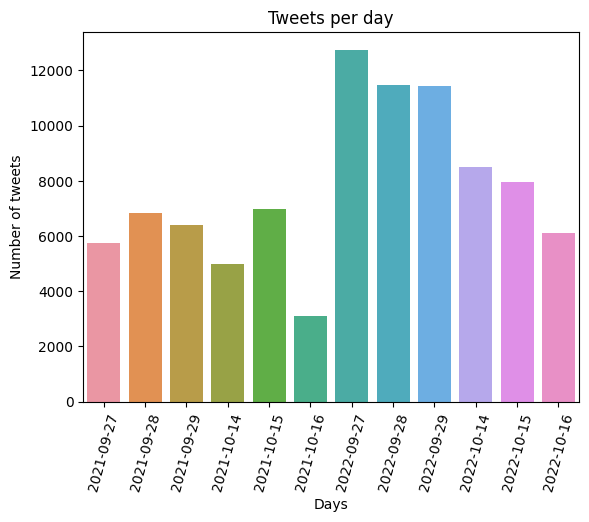

In [31]:
tweets_day = sns.barplot(
    x = df_dates['date'].dt.date.astype(str),
     y = df_dates['count'])
plt.title("Tweets per day")
plt.xlabel("Days")
plt.ylabel("Number of tweets")
plt.xticks(rotation=75)
plt.show()

In [69]:
df_dates.dtypes

df_dates['event'] = ('abortion_21', 'abortion_21', 'abortion_21', 'miscarriage_21', 'miscarriage_21', 'miscarriage_21', 'abortion_22', 'abortion_22', 'abortion_22', 'miscarriage_22', 'miscarriage_22', 'miscarriage_22')

/tmp/ipykernel_22454/1145497738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dates['event'] = ('abortion_21', 'abortion_21', 'abortion_21', 'miscarriage_21', 'miscarriage_21', 'miscarriage_21', 'abortion_22', 'abortion_22', 'abortion_22', 'miscarriage_22', 'miscarriage_22', 'miscarriage_22')


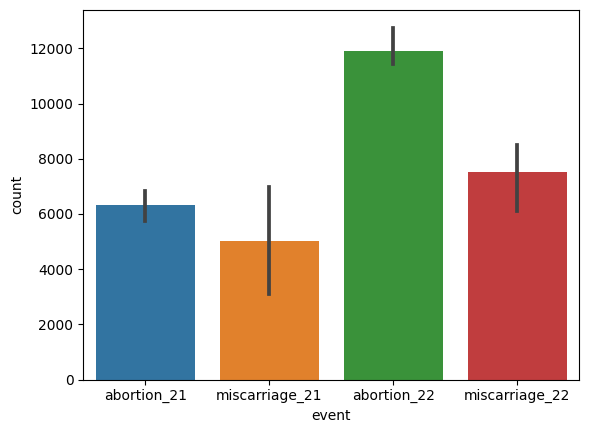

In [70]:
tweets_event = sns.barplot(
    x = df_dates['event'], 
    y = df_dates['count'])

In [53]:
abortion = []

IndexingError: Too many indexers

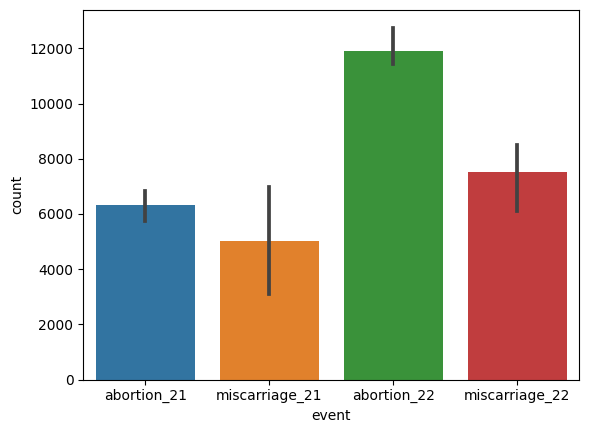

In [70]:
tweets_event = sns.barplot(
    x = df_dates['event'], 
    y = df_dates['count'])

In [ ]:
#if df_dates['date'].iat[i] == ("2021-09-27": '2021-09-28', '2021-09-29'):
#    df_dates['event'] = 'Abortion_21'
#elif df_dates['date'] == ('2022-09-27') & ('2022-09-28') & ('2022-09-29'):
 #   df_dates['event'] = 'Abortion_22'
#elif df_dates['date'] == ('2021-10-14', '2021-10-15', '2021-10-16'):
 #   df_dates['event'] = 'Miscarriage_21'
#elif df_dates['date'] == ('2022-10-14', '2022-10-15', '2022-10-16'):
 #   df_dates['event'] = 'Miscarriage_22'

In [81]:
def categorize(x):
    if x == "2021-09-27":
        return 'abortion_21'
    if x == "2021-09-28":
        return 'abortion_21'
    if x == "2021-09-29":
        return 'abortion_21'
    if x == "2021-10-14":
        return 'miscarriage_21'
    if x == "2021-10-15":
        return 'miscarriage_21'
    if x == "2021-10-16":
        return 'miscarriage_21'
    if x == "2022-09-27":
        return 'abortion_22'
    if x == "2022-09-28":
        return 'abortion_22'
    if x == "2022-09-29":
        return 'abortion_22'
    if x == "2022-10-14":
        return 'miscarriage_22'
    if x == "2022-10-15":
        return 'miscarriage_22'
    if x == "2022-10-16":
        return 'miscarriage_22'

    
df_dates['event'] = df_dates['date'].apply(categorize)
  
df_dates

/tmp/ipykernel_22454/1688547159.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dates['event'] = df_dates['date'].apply(categorize)


,date,count,event
4,2021-09-27,5740,None
6,2021-09-28,6824,None
7,2021-09-29,6406,None
0,2021-10-14,4993,None
2,2021-10-15,6977,None
3,2021-10-16,3098,None
12,2022-09-27,12753,None
14,2022-09-28,11471,None
15,2022-09-29,11443,None
8,2022-10-14,8511,None


In [71]:
def categorize(df):
    for row in df_dates:
        if df_dates.loc[(df_dates['event'] == 'abortion_21')]:
            return abortion.append()
  

    
    for row in df_dates:
        if df_dates.loc[(df_dates['event'] == 'abortion_21')]:
            return abortion.append()

abortion1 = df_dates.loc[(df_dates['date'] == "2021-09-27")]

abortion_date_21 = [('2021-09-27'), ('2021-09-28'), ('2021-09-29')]

categorize(df_dates)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [68]:
abortion_date_21

['2021-09-27', '2021-09-28', '2021-09-29']

In [ ]:
#for i, row in df_dates.append(df_dates['event']):
 #   if df_dates['date'].iat[i] == "2021-09-27":
  #      df_dates['event'] = 'Abortion_21'
   # elif df_dates['date'] == ('2022-09-27') & ('2022-09-28') & ('2022-09-29'):
    #    df_dates['event'] = 'Abortion_22'

### Analysis of tweets per hour


# Sentiment Analysis
### Interactions and emotions

To study wether the tweets with more interactions have a positive or negativ emotion we have to:
1. Group by cols
2. Choose a sample population with the most liked tweets
3. Perform sentiment analysis


In [ ]:
#Anlyze all tweets to get the most positive and the most negative ones
#Choose only the relevant columns for the study

df_allsentiment = df[['clean_text', 'author.username', 'public_metrics.retweet_count', 'public_metrics.reply_count', 'public_metrics.like_count']]
df_allsentiment.rename(columns = {'clean_text':'text'}, inplace = True)

def sentiment_analysis_polarity_NLTK(df):
    '''
    Given a dataframe with tweets, it add 4 new columns to express sentiment polarity:
    negative score, positive score, neutral score and compound
    '''

    sia = SentimentIntensityAnalyzer()

    tweets = df_allsentiment['text']

    negative_values = []
    neutral_values = []
    positive_values = []
    compound_values = []

    for tweet in tweets:
        polarity_dict = sia.polarity_scores(tweet)
        
        negative_values.append(polarity_dict['neg'])
        neutral_values.append(polarity_dict['neu'])
        positive_values.append(polarity_dict['pos'])
        compound_values.append(polarity_dict['compound'])

    df['polarity_negative'] = negative_values
    df['polarity_positive'] = positive_values
    df['polarity_neutral'] = neutral_values
    df['polarity_compound'] = compound_values
    
    return df


df_allsentiment = sentiment_analysis_polarity_NLTK(df_allsentiment)

In [ ]:
#Function to obtain subjectivity
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Function for general polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity

df_allsentiment['subjectivity'] = df_allsentiment['text'].apply(subjectivity)
df_allsentiment['polarity'] = df_allsentiment['text'].apply(polarity)

In [ ]:
#Plot word cloud
#Important to add the collocations=False, otherwise we will get composite word results as 'Abortion ban', 'Abortion law', etc.
allWords = ' '.join( [text.strip() for text in df_allsentiment['text']] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, collocations = False).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_allsentiment['analysed'] = df_allsentiment['polarity'].apply(getAnalysis)


In [ ]:
df_allsentiment

In [ ]:
#df_subjective = df_allsentiment.sort_values(by = ['subjectivity'], ascending = False)['subjectivity']

In [ ]:
from pandas.core.apply import frame_apply

#Change column names
df_allsentiment.columns = ['text', 'username', 'retweets', 'replies', 'likes', 'negative', 'positive', 'neutral', 'composed', 'subjectivity', 'polarity', 'analysed']

In [ ]:
#Plot polarity and subjectivity
plt.figure(figsize=(8,6))
plt.scatter(df_allsentiment['polarity'], df_allsentiment['subjectivity'], color = 'Blue')
plt.title('Sentiment Analysis (pol & sub)')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [ ]:
#Percentages of positive tweets
positivetwt = df_allsentiment[df_allsentiment['analysed'] == 'Positive']
positiveper100 = round( (positivetwt.shape[0]/df_allsentiment.shape[0])*100, 1)
print('The percentaje of positives is:', positiveper100)

#Percentages of positive tweets
negativetwt = df_allsentiment[df_allsentiment['analysed'] == 'Negative']
negativeper100 = round( (negativetwt.shape[0]/df_allsentiment.shape[0])*100, 1)
print('The percentaje of negatives is:', negativeper100)

#Percentages of neutral tweets
neutraltwt = df_allsentiment[df_allsentiment['analysed'] == 'Neutral']
neutralper100 = round( (neutraltwt.shape[0]/df_allsentiment.shape[0])*100, 1)
print('The percentaje of neutrals is:', neutralper100)

In [ ]:
#Visualize the counts ( or percentages)
plt.title('Sentiment analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_allsentiment['analysed'].value_counts().plot(kind = 'bar')

In [ ]:
from matplotlib import pyplot
%matplotlib inline
pyplot.scatter(df_allsentiment['positive'], df_allsentiment['likes'])

## Correlation analysis

In [ ]:
sns.pairplot(df_allsentiment)